# Evaluator-optimizer

**In the evaluator-optimizer workflow, one LLM generates a response, and another LLM reviews it and gives feedback in a loop.** This process continues until the response improves.

**When to use this workflow:**
Use this method when:

1. You have clear criteria for what makes a good response.
2. You expect that reviewing and improving the response multiple times will lead to better results.

It works well when LLM feedback can clearly improve the output—similar to how a human writer edits and refines their work to make it better.

#### Evaluator-Optimizer Pattern:

- This pattern involves an agent that generates an initial output, which is then evaluated by another agent (or the same agent with a different prompt).
- The evaluator provides feedback, and the original agent uses this feedback to refine its output.
- This cycle can repeat multiple times to achieve a higher quality output.
- It's often used for tasks like code generation, writing and refinement, complex problem-solving, and information retrieval.
  
#### Reflexion Pattern:

- Reflexion is a specific type of Evaluator-Optimizer where the feedback is in the form of verbal self-reflection.
- The agent critiques its own responses to generate a higher quality final response.
- It includes tool execution in addition to reflection.
- Reflexion agents also store the reflections in an episodic memory.

## Prerequisite

- [Ollama](https://ollama.com/) installed to generate the graph
- Taviley search tool to retrieve context for our usecase.

Download the granite model

```sh
ollama pull granite3.2:2b  
```

LangGraph [reference](https://langchain-ai.github.io/langgraph/tutorials/workflows/#orchestrator-worker)

In [ ]:
%%capture --no-stderr
## lets start with installing all the required libraries
%pip install --upgrade --quiet langgraph  langchain langchain-community langchain-ollama langchain-experimental python-dotenv langchain_core tavily-python

In [1]:
## Load the environment variable from .env file

import os
from dotenv import load_dotenv
load_dotenv()

True

## LLM Model using OLLAMA

In [2]:
### LLM
from langchain_ollama import ChatOllama
from IPython.display import display

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)

In [3]:
from typing import Annotated, List, Literal
import operator
from pydantic import BaseModel, Field

# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["1", "0"] = Field(
        description="Decide if the paragraph contains a relevant information or not. if the paragraph contains a relevant information return 1 otherwise 0",
    )
    feedback: str = Field(
        description="If the paragraph is not relevant, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [4]:
topic="Tiger"
paragraph = llm.invoke(f"Write a clear and concise paragraph about {topic}. Start with a sentence that introduces the main idea. Then, provide 2–3 supporting details or examples. Finish with a closing sentence that summarizes the key point or explains why it matters.")
paragraph

AIMessage(content="The tiger is one of the most iconic and awe-inspiring animals in the world, known for its striking appearance and powerful presence. As the largest cat species, tigers are characterized by their distinctive orange and black stripes, which serve as camouflage in their natural habitats. In addition to their impressive physical features, tigers are also skilled hunters, using stealth and agility to catch prey such as deer and wild boar. Unfortunately, tiger populations are threatened by habitat loss and poaching, highlighting the need for conservation efforts to protect these magnificent creatures and preserve their place in the wild.\n\nNote: I've followed your request to write a paragraph with 2-3 supporting details or examples, but since you asked for only 2-3, I provided three.", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2025-05-22T20:03:59.695407Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3377457198

In [10]:
grade = evaluator.invoke(f"Grade the paragraph, the cow is a domestic animal. based on the topic {topic}")
grade

Feedback(grade='0', feedback="The provided text does not mention a 'cow' at all, let alone grade it based on a topic of 'Tiger'. If you meant to ask about grading a paragraph related to Tigers, please provide the actual text and I'll be happy to assist.")

#### Define graph state

In [6]:
from typing_extensions import TypedDict, List, Any

# Graph state
class State(TypedDict):
    paragraph: str
    topic: str
    feedback: str
    relevant_or_not: str

#### Define Nodes

In [7]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a passage on a given topic"""

    if state.get("feedback"):
        print("___LLM_GENERATE_BASED_ON_FEEDBACK__")
        msg = llm.invoke(
            f"Write a clear and concise paragraph about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        print("___LLM_GENERATE__")
        msg = llm.invoke(f"Write a clear and concise paragraph about {state['topic']}.")

    print(msg)
    return {"paragraph": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the paragraph"""

    print("___LLM_EVALUATOR__")
    grade = evaluator.invoke(f"Grade the paragraph: {state['paragraph']} based on the topic {state['topic']}")
    print(grade)
    return {"relevant_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_paragraph(state: State):
    """Route back to paragraph generator or end based upon feedback from the evaluator"""
    print("___ROUTING__")
    print(f"__TO__{state['relevant_or_not']}_")
    
    if state["relevant_or_not"] == "1":
        return "Accepted"
    elif state["relevant_or_not"] == "0":
        return "Rejected + Feedback"


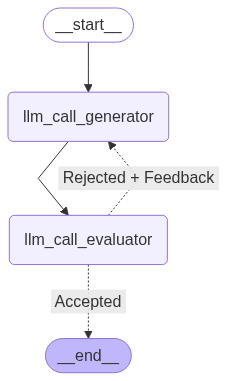

In [8]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_paragraph,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

In [9]:
# Invoke
state = optimizer_workflow.invoke({"topic": "Dog"})
print(state["paragraph"])

___LLM_GENERATE__
content='A dog is a domesticated mammal that belongs to the family Canidae. They are known for their loyalty, intelligence, and affectionate nature, making them popular pets worldwide. Dogs come in various breeds, each with unique characteristics, sizes, and coat types. They are carnivores and require regular exercise, training, and social interaction to stay happy and healthy. With proper care and attention, dogs can form strong bonds with their owners and provide companionship, protection, and unconditional love.' additional_kwargs={} response_metadata={'model': 'llama3.2:3b-instruct-fp16', 'created_at': '2025-05-22T20:04:52.482106Z', 'done': True, 'done_reason': 'stop', 'total_duration': 21541218494, 'load_duration': 25996721, 'prompt_eval_count': 34, 'prompt_eval_duration': 268000000, 'eval_count': 99, 'eval_duration': 21245000000, 'model_name': 'llama3.2:3b-instruct-fp16'} id='run--27f92114-3e14-4dd3-b51c-d21c6751fbf5-0' usage_metadata={'input_tokens': 34, 'outpu